# ENSO_lifecycle: temporal evolution of SST anomalies in the central equatorial Pacific

Computes the temporal root mean square error (RMSE) of sea surface temperature anomalies (SSTA) in the Niño3.4 region (horizontal average over 5°S–5°N, 170°W–120°W) between model and observations. The analysis spans 6 years centred on ENSO peak years to evaluate the ability of the model to capture the full lifecycle of ENSO events, including onset, peak, and decay phases.

## Datasets Used for Temporal Evolution Comparison
The following reference datasets are employed to evaluate the ENSO lifecycle in model simulations:

- **TropFlux** (1979–2018): The primary dataset for comparison, offering accurate surface fluxes and anomalies for tropical climate studies.
  
## Additional datasets include:

- **20CRv2** (1871–2012): A historical reanalysis dataset reconstructing global atmospheric conditions using surface pressure observations.
- **ERA-Interim** (1979–2018): A widely used reanalysis product providing consistent, high-resolution estimates of atmospheric and surface variables.
- **ERSSTv5** (1854–2018): A globally gridded SST anomaly dataset optimised for long-term climate monitoring and ENSO analysis.
- **HadISST** (1870–2018): A comprehensive dataset of SST and sea ice, blending historical observations with reconstructions.
- **NCEP2** (1979–2018): A second-generation reanalysis dataset delivering improved global atmospheric and surface data.

In [1]:
from esmvalcore.dataset import Dataset

In [2]:
model_datasets = {
"ACCESS-ESM1-5": 
    Dataset(
    short_name='ts',
    project='CMIP6',
    mip="Amon",
    exp="historical",
    ensemble="r1i1p1f1",
    timerange="18500101/20190101",
    dataset="ACCESS-ESM1-5",
    grid="gn"
),
## Note: It is possible to use tos (sea_surface_temperature; degC; ocean; mon) 
# "ACCESS-ESM1-5": 
#     Dataset(
#     short_name='tos',
#     project='CMIP6',
#     mip="Omon",
#     exp="historical",
#     ensemble="r1i1p1f1",
#     timerange="18500101/20190101",
#     dataset="ACCESS-ESM1-5",
#     grid="gn"
# )
}

obs_datasets = {
"HadISST": 
    Dataset(
    short_name='ts',
    dataset='HadISST',
    mip="Amon",
    project='OBS',
    type='reanaly',
    tier=2),
# "ERSSTv5":
#     Dataset(
#     short_name='tos',
#     dataset='NOAA-ERSSTv5',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     tier=2),
# "ERA-Interim": 
#     Dataset(
#     short_name='tos',
#     dataset='ERA-Interim',
#     mip="Omon",
#     project='OBS6',
#     type='reanaly',
#     timerange="19790101/20190101",
#     tier=3)
}

## Add Ancillary files

In [3]:
for name, dataset in model_datasets.items():
    dataset.add_supplementary(short_name='sftlf', mip="fx")
    dataset.add_supplementary(short_name="areacella", mip="fx")

In [4]:
model_datasets = {name: dataset.load() for name, dataset in model_datasets.items()}
obs_datasets = {name: dataset.load() for name, dataset in obs_datasets.items()}

(for file /g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/fx/sftlf/gn/v20191115/sftlf_fx_ACCESS-ESM1-5_historical_r1i1p1f1_gn.nc)


In [5]:
from esmvalcore.preprocessor import anomalies
from esmvalcore.preprocessor import area_statistics
from esmvalcore.preprocessor import rolling_window_statistics
from esmvalcore.preprocessor import meridional_statistics
from esmvalcore.preprocessor import convert_units
from esmvalcore.preprocessor import extract_region
from esmvalcore.preprocessor import extract_time
from esmvalcore.preprocessor import extract_month
from esmvalcore.preprocessor import regrid
from esmvalcore.preprocessor import detrend
from esmvalcore.preprocessor import mask_landsea
import iris

import matplotlib.pyplot as plt
import iris.quickplot as qplt
import numpy as np
import xarray as xr
import sacpy as scp
from esmvalcore.iris_helpers import date2num 
# [d for d in t_coord.units.num2date(t_coord.points)]

In [6]:
def sst_enso_n34(cube):
    nino34_latext_region = {"start_longitude": 190., "end_longitude": 240., "start_latitude": -5., "end_latitude": 5.}
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = convert_units(cube, units="degC")
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = extract_region(cube, **nino34_latext_region)
    # remove time mean
    cube = anomalies(cube, period='monthly') 
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)##rolling window cuts off months?
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = area_statistics(cube,operator='mean')
    # detrend?
    return cube

def sst_meridional(cube): ##along latitude for area
    nino34_latext_region = {"start_longitude": 160., "end_longitude": 280., "start_latitude": -5., "end_latitude": 5.}
    cube = convert_units(cube, units="degC")
    cube = extract_time(cube, start_year=1900, start_month=1, start_day=1, end_year=2014, end_month=12, end_day=31)    
    cube = mask_landsea(cube, mask_out="land") #shp or land fraction
    cube = anomalies(cube, period='monthly')
    cube = extract_region(cube, **nino34_latext_region)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = rolling_window_statistics(cube, coordinate='time', operator='mean', window_length=5)
    cube = regrid(cube, target_grid="1x1", scheme="linear")
    cube = meridional_statistics(cube,operator='mean')
    return cube

#rmse

In [7]:
model_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in model_datasets.items()}
model_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in model_datasets.items()}

obs_datasets_prep1 = {name: sst_enso_n34(dataset) for name, dataset in obs_datasets.items()}
obs_datasets_prep2 = {name: sst_meridional(dataset) for name, dataset in obs_datasets.items()}


/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4067: IrisUserWarning: Collapsing spatial coordinate 'latitude' without weighting
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning: The bounds of coordinate 'time' were ignored in the rolling window operation.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/iris/cube.py:4620: IrisIgnoringBoundsWarning:

## Diagnostic Level 1

The first level shows the diagnostic used to compute the metric and highlight the main differences between the model and the reference.

In [8]:

def sst_regressed(n34_dec, n34, n34_area):
    leadlagyr = 3 #rolling window cut off, not include first year
    n34_dec_ct = n34_dec[leadlagyr:-leadlagyr]
    event_years = n34_dec_ct.time.dt.year #
    # Ensure that the selected years are not the last or second last year in the n34 dataset
    years_of_interest_array = []
    
    # Fill the array with the years of interest for each event year 
    for i, year in enumerate(event_years):# 2:-3 for dec        
        years_of_interest_array.append([year.values - 2, year.values - 1, year.values, year.values + 1, year.values + 2, year.values + 3])
    
    n34_selected = []
    n34_area_selected = []
    for i in range(len(years_of_interest_array)): #creates sst_time_series
        # Select the data for the current year and append it to n34_selected #n34 is not dec month only
        n34_selected.append(n34.sel(time=n34['time.year'].isin(years_of_interest_array[i])))
        n34_area_selected.append(n34_area.sel(time=n34_area['time.year'].isin(years_of_interest_array[i])))

    # 1) linear regression of sst_time_series on sst_enso
    slope = scp.LinReg(n34_dec_ct.values, n34_selected).slope
    slope_area = scp.LinReg(n34_dec_ct.values, n34_area_selected).slope

    return slope, slope_area

In [9]:
model_n34 = model_datasets_prep1["ACCESS-ESM1-5"]
model_n34_dec = extract_month(model_datasets_prep1["ACCESS-ESM1-5"],12)
model_n34_area = model_datasets_prep2["ACCESS-ESM1-5"]


obs_n34 = obs_datasets_prep1["HadISST"]
obs_n34_dec = extract_month(obs_datasets_prep1["HadISST"],12)
obs_n34_area = obs_datasets_prep2["HadISST"]


In [10]:
## metric computation - rmse of slopes
cb_out = {'nino34':model_n34, 'n34_dec':model_n34_dec, 'n34_area':model_n34_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}

model = sst_regressed(darray_dict['n34_dec'], darray_dict['nino34'], darray_dict['n34_area'])
## obs
cb_out = {'nino34':obs_n34, 'n34_dec':obs_n34_dec, 'n34_area':obs_n34_area}
darray_dict = {cbname: xr.DataArray.from_iris(cb) for cbname, cb in cb_out.items()}
obs = sst_regressed(darray_dict['n34_dec'], darray_dict['nino34'], darray_dict['n34_area'])

rmse = np.sqrt(np.mean((obs[0] - model[0]) ** 2))
rmse

/g/data/xp65/public/apps/med_conda/envs/esmvaltool-0.4/lib/python3.11/site-packages/sacpy/linger_cal.py:45: RuntimeWarning: invalid value encountered in sqrt
  t = corr / (np.sqrt(1 - corr**2) + EPS) * np.sqrt(Num0 - 2)


0.18226898

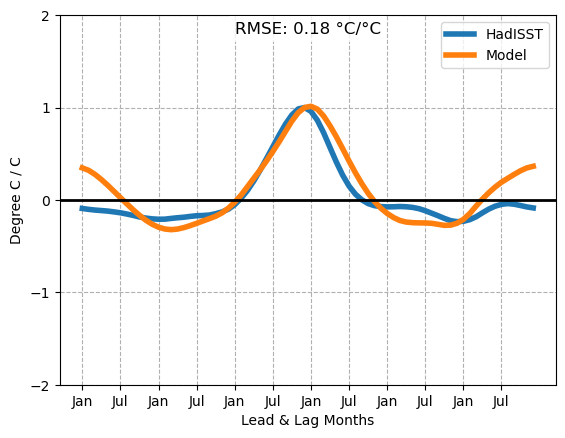

In [11]:
months = np.arange(1, 73) - 36

# Plot the slope
plt.plot(months, obs[0], label='HadISST', lw=4)
plt.plot(months, model[0], label='Model', lw=4)

# Draw a black dashed line at y=0.25
# plt.axhline(y=0.25, color='black', linestyle='--', label='0.25 threshold')

# Draw a thicker line at y=0
plt.axhline(y=0, color='black', linewidth=2) #, label='Zero Line')

# Define custom ticks for the x-axis (every 6 months)
xticks = np.arange(1, 73, 6) - 36  # Adjust for lead/lag months
xtick_labels = ['Jan', 'Jul'] * (len(xticks) // 2)

# Set the labels and titles
plt.xlabel('Lead & Lag Months')
plt.ylabel('Degree C / C')
plt.legend()
plt.grid(linestyle='--')

# Apply the custom ticks and labels to the x-axis
plt.xticks(xticks, xtick_labels)
plt.yticks(np.arange(-2,2.5, step=1))

# Adding RMSE text on top of the plot
plt.text(0.5, 0.95, f'RMSE: {rmse:.2f} °C/°C', fontsize=12, ha='center', transform=plt.gca().transAxes,
         bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))
# Show the plot
plt.show()

Figure 1: Temporal evolution of sea surface temperature anomalies (SSTA) in the central equatorial Pacific (Niño 3.4 region average), illustrating the ENSO-associated variability. The model tends to exhibit overly frequent transitions between negative and positive SSTA phases. The black curve represents the reference data, while the blue curve corresponds to the model output. The derived metric is the temporal root mean square error (RMSE) between the model and reference curves.

# Diagnostic Level 2

The second level shows the broader picture to better understand the spatial-temporal pattern of ENSO: the Hovmöller of the anomalies in the equatorial Pacific.

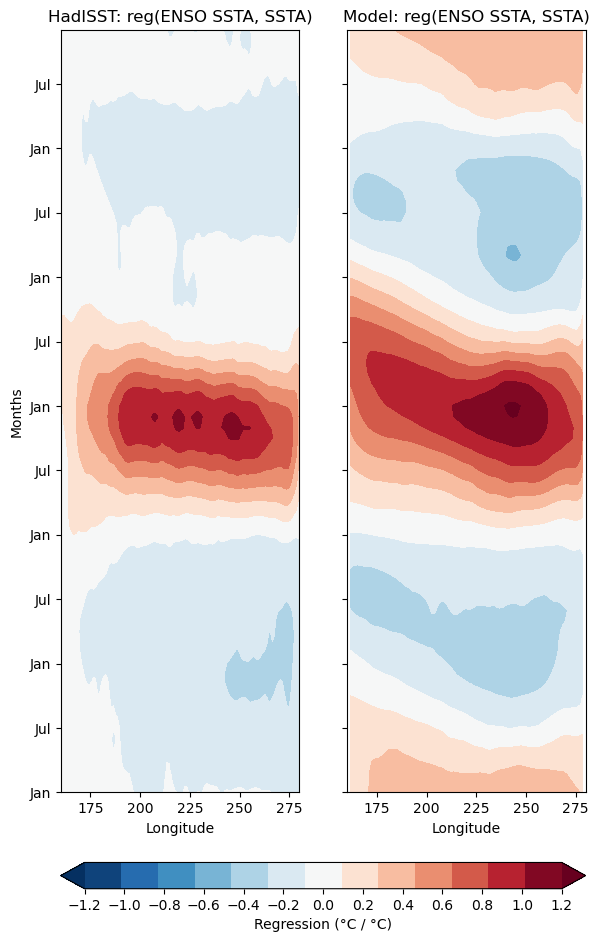

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define custom ticks for the y-axis (every 6 months)
yticks = range(1, 73, 6)
ytick_labels = ['Jan', 'Jul'] * (len(yticks) // 2)

# Define shared color limits and colorbar ticks
vmin = -1.2
vmax = 1.2
ticks = np.arange(vmin, vmax + 0.2, 0.2)  # Ticks from -1.2 to 1.2 at intervals of 0.2

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 12), sharey=True)

# First subplot: HadISST
c1 = ax1.contourf(
    obs_n34_area.coord('longitude').points,
    range(1, 73),
    obs[1],
    levels=np.linspace(vmin, vmax, 14),
    cmap='RdBu_r',
    extend='both'  # Allow for values beyond vmin and vmax
)
ax1.set_ylabel('Months')
ax1.set_xlabel('Longitude')
ax1.set_xlim([160, 280])
ax1.set_title('HadISST: reg(ENSO SSTA, SSTA)')
ax1.set_yticks(yticks)
ax1.set_yticklabels(ytick_labels)

# Second subplot: Model
c2 = ax2.contourf(
    model_n34_area.coord('longitude').points,
    range(1, 73),
    model[1],
    levels=np.linspace(vmin, vmax, 14),
    cmap='RdBu_r',
    extend='both'  # Allow for values beyond vmin and vmax
)
ax2.set_xlabel('Longitude')
ax2.set_title('Model: reg(ENSO SSTA, SSTA)')
ax2.set_xlim([160, 280])

# Adjust the layout to add space for the colorbar
fig.subplots_adjust(bottom=0.15, right=1.0)  # Adjust bottom margin to fit colorbar

# Add a horizontal colorbar beneath the subplots
cbar = fig.colorbar(c1, ax=[ax1, ax2], label='Regression (°C / °C)', orientation='horizontal', ticks=ticks, fraction=0.05, pad=0.08)

# Display the plot
plt.show()


Figure 2: spatial-temporal structure of sea surface temperature anomalies (SSTA) associated with ENSO in the equatorial Pacific (5°S-5°N average), showing usually the too frequent swing from negative to positive SSTA, along with maximum anomalies during ENSO peak lasting too long. The left and right Hovmöllers show respectively the reference and the model.